In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import scipy.io as io

plt.rc("font", family=["Helvetica", "Arial"]) #skifter skrifttype
plt.rc("axes", labelsize=18)   #skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=16, direction="out")  #skriftstørrelse af ticks og viser ticks øverst
plt.rc("ytick", labelsize=16, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=16)

In [2]:
entries_list_sT = os.listdir(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/glas til luft/s/Datafiler/transmitteret")
entries_list_sR = os.listdir(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/glas til luft/s/Datafiler/reflekteret")

t1_90 = 90*np.pi/180

def func(x, a):
    return a

d = io.loadmat(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/baggrund måling.mat")
d_offset = d.get("A")
d_offset = np.reshape(d_offset, (len(d_offset)))

t = np.linspace(0, 50, len(d_offset))
mean_Voff, pcovoff = curve_fit(func, t, d_offset, absolute_sigma=True)
usOff = np.sqrt(np.diag(pcovoff))

d = io.loadmat(r"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/glas til luft/s - 90 grader med krystal.mat")
d90 = d.get("A")
d90 = np.reshape(d90, (len(d90)))


t = np.linspace(0, 50, len(d90))
mean_V90, pcov90 = curve_fit(func, t, d90, absolute_sigma=True)
us90 = np.sqrt(np.diag(pcov90))
mean_V90 = mean_V90 - mean_Voff


In [3]:
def get_ts_Vs(t, entries):
    if t == "T":
        rempart = "t("
        file_dest = "transmitteret"
    else:
        rempart = "r("
        file_dest = "reflekteret"
        
    ts = np.zeros((len(entries), 2))
    Vs = np.zeros((len(entries),2))
    for i, file in enumerate(entries):
        name = file.replace(rempart, "")
        name = name.replace(".mat", "")
        name = name.replace(")", "")
        indx = name.find(",")
        ts12 = float(name[0:indx])*np.pi/180, float(name[indx + 1:len(name)])*np.pi/180
        ts[i] = ts12
        
    for i, file in enumerate(entries):
        dat = io.loadmat(f"/Users/karsten/eksperimental/Experimentel-Physics-2/Tredje labdag/glas til luft/s/Datafiler/{file_dest}/{file}")
        V = dat.get("A")
        V = np.reshape(V, (len(V)))
        xs = np.linspace(0, 50, len(V))
        fitted, pcov = curve_fit(func, xs, V, absolute_sigma=True)
        perr1 = np.sqrt(np.diag(pcov))
        Vs[i][0] = fitted - mean_Voff
        Vs[i][1] = perr1
        
    return Vs, ts

In [4]:
mean_VsT, ts_trans = get_ts_Vs("T", entries_list_sT)
mean_VsR, ts_ref = get_ts_Vs("R", entries_list_sR)

In [5]:
Ts = mean_VsT/mean_V90
Rs = mean_VsR/mean_V90

print(Ts)

[[ 1.05965904e+00  2.95100991e-03]
 [ 1.00606093e+00  2.95100992e-03]
 [ 1.08235997e+00  2.95100992e-03]
 [ 1.11062167e+00  2.95100991e-03]
 [ 1.90228164e-02  2.95100989e-03]
 [ 1.03778805e+00  2.95100991e-03]
 [ 1.05504604e+00  2.95100990e-03]
 [ 9.81574573e-01  2.95100991e-03]
 [ 9.37920317e-01  2.95100991e-03]
 [ 8.83715256e-01  2.95100990e-03]
 [ 8.88857857e-01  2.95100992e-03]
 [ 7.92526238e-01  2.95100991e-03]
 [ 7.03448894e-01  2.95100991e-03]
 [ 4.34077872e-01  2.95100992e-03]
 [ 7.88934952e-03  2.95100991e-03]
 [-6.70989527e-04  2.95100992e-03]
 [ 1.00568201e+00  2.95100991e-03]]


<ipython-input-6-576c01a794ec>:6: RuntimeWarning: invalid value encountered in arcsin
  theta_ag = np.arcsin(n*np.sin(theta))


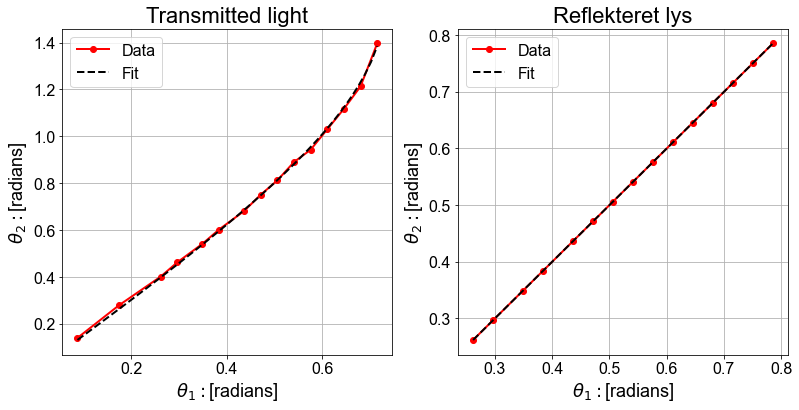

In [6]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title("Reflekteret lys")
axs[0].set_title("Transmitted light")

def snell(theta, n):
    theta_ag = np.arcsin(n*np.sin(theta))
    return theta_ag

theta1T = np.zeros(len(ts_trans))
theta2T = np.zeros(len(ts_trans))

theta1R = np.zeros(len(ts_ref))
theta2R = np.zeros(len(ts_ref))

i = 0
for t1, t2 in ts_trans:
    theta1T[i] = t1
    theta2T[i] = t2 + t1
    i = i + 1
    
i = 0
for t1, t2 in ts_ref:
    theta1R[i] = t1
    theta2R[i] = t1
    i = i + 1
    
theta1T1 = np.sort(theta1T)[0:len(theta1T) - 2]
theta2T1 = np.sort(theta2T)[0:len(theta2T) - 2]

axs[0].plot(theta1T1, theta2T1, 'o-', c='r', lw=2, label="Data")
axs[1].plot(theta1R, theta2R, 'o-', c='r', lw=2, label="Data")

nT, pcovT = curve_fit(snell, theta1T1, theta2T1)
nR, pcovR = curve_fit(snell, theta1R, theta2R, absolute_sigma=True)

theta_T = np.linspace(min(theta1T1), max(theta1T1))
theta_R = np.linspace(min(theta1R), max(theta1R))

axs[0].plot(theta_T, snell(theta_T, nT), c='k', ls="--", label="Fit", lw=2)
axs[1].plot(theta_R, snell(theta_R, nR), c='k', ls="--", label="Fit", lw=2)

for ax in axs:
    ax.grid()
    ax.set_xlabel(r"$\theta_1: $[radians]")
    ax.set_ylabel(r"$\theta_2: $[radians]")
    ax.legend()


In [17]:
print(nT, np.sqrt(np.diag(pcovT)))
uncer = 0.5 # DEGREES
sigma_radian = np.pi/180 * uncer
print(sigma_radian)


[1.4979804] [0.00196574]
0.008726646259971648


[ 0.09530459  0.03803748  0.03960171  0.03994986  0.04493675  0.06107795
  0.08494098  0.09766932  0.10036994  0.14371844  0.03863571 -0.02022014
  0.54686479  0.85714747  0.87047924]
[0.09530459 0.03803748 0.03960171 0.03994986 0.04493675 0.06107795
 0.08494098 0.09766932 0.10036994 0.14371844 0.54686479 0.85714747
 0.87047924]


<ipython-input-29-e57140b141c1>:12: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(n_komb*np.sin(theta_1))
<ipython-input-29-e57140b141c1>:7: RuntimeWarning: invalid value encountered in arcsin
  theta_2 = np.arcsin(n_komb*np.sin(theta_1)) #Indsæt kombination af brydningsindekser, så det passer med f.eks. ns = n_a/n_g, eller omvendt


Text(0, 0.5, '$R_s$')

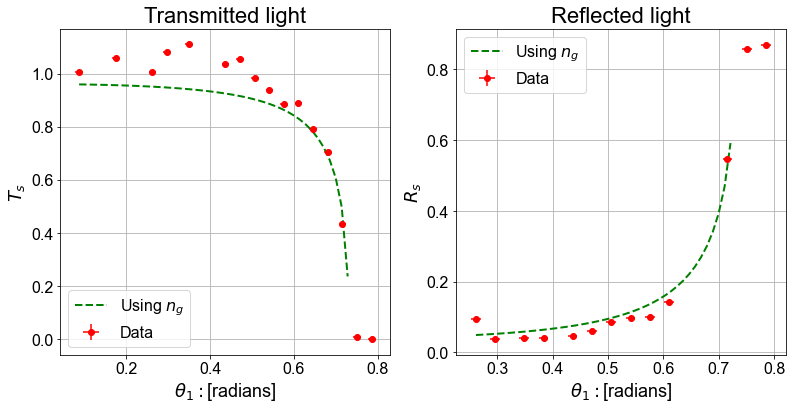

In [29]:
fig, axs = plt.subplots(1,2, figsize=(13,6))
axs[1].set_title("Reflected light")
axs[0].set_title("Transmitted light")


def Rkoef(theta_1, n_komb): #Gælder kun for S polariseret lys
    theta_2 = np.arcsin(n_komb*np.sin(theta_1)) #Indsæt kombination af brydningsindekser, så det passer med f.eks. ns = n_a/n_g, eller omvendt
    R_s = np.sin(theta_1 - theta_2)**2/(np.sin(theta_1 + theta_2)**2)
    return R_s

def Tkoef(theta_1, n_komb): #Gælder kun for S polariseret lys
    theta_2 = np.arcsin(n_komb*np.sin(theta_1))
    T_s = np.sin(2*theta_1)*np.sin(2*theta_2)/(np.sin(theta_1 + theta_2)**2)
    return T_s

T_uc = []
R_uc = []


theta1T_n = np.delete(theta1T, 4)
Ts_n = np.delete(np.transpose(Ts)[0], 4)
theta2T_n = np.delete(theta2T, 4)

for i in range(11):
    if Ts_n[i] < 0.2:
        theta1T_n = np.delete(theta1T_n, i)
        Ts_n = np.delete(Ts_n, i)
        theta2T_n = np.delete(theta2T_n, i)


for i in range(len(theta1T_n)):
    T_uc.append(2.95100991e-03)
    

theta1R_n = np.delete(theta1R, len(theta1R) - 4)
theta1R_n = np.delete(theta1R_n, len(theta1R_n) - 4)
R_n = np.transpose(Rs)[0]
print(R_n)
R_n = np.delete(R_n, len(R_n) - 4)
R_n = np.delete(R_n, len(R_n) - 4)
print(R_n)

for i in range(len(theta1R_n)):
    R_uc.append(0.00295101)

axs[0].errorbar(theta1T_n, Ts_n, xerr=sigma_radian, yerr=T_uc,fmt='o', c='r', label="Data")
axs[1].errorbar(theta1R_n, R_n, xerr=sigma_radian, yerr=R_uc,fmt='o', c='r', label="Data")


theta_T = np.linspace(min(theta1T_n), max(theta1T_n))
theta_R = np.linspace(min(theta1R), max(theta1R))

axs[0].plot(theta_T, Tkoef(theta_T, nT), ls="--", c="g", lw=2, label=r"Using $n_g$")
axs[1].plot(theta_R, Rkoef(theta_R, nT), ls="--", c="g", lw=2, label=r"Using $n_g$")

for ax in axs:
    ax.grid()
    ax.legend()
    ax.set_xlabel(r"$\theta_1: $[radians]")
axs[0].set_ylabel(r"$T_s$")
axs[1].set_ylabel(r"$R_s$")


In [30]:
print(np.transpose(np.array([nT, np.sqrt(np.diag(pcovT))]))[0])

[1.4979804  0.00196574]


# P-værdi og Chi^2 min værdi - for snells lov fit

In [31]:
yerr = np.zeros(len(theta2T1))
for i in range(len(yerr)):
    yerr[i] = 0.5*np.pi/180 #Fejlen på vores vinkler

v = len(theta2T1) - 1

chmin = np.sum(((theta2T1-snell(theta1T1, nT))/yerr)**2)
Pkhi = round(1 - stats.chi2.cdf(chmin,v), 2) 

In [32]:
print(v - 2*np.sqrt(v), " < ", chmin, " < ", v + 2*np.sqrt(v))

6.516685226452117  <  16.091761050787156  <  21.48331477354788


In [33]:
print(Pkhi)

0.31
